# Review of Statistics

This notebook shows some basic statistics needed for this course in financial econometrics. Details are in the first chapter of the lecture notes (pdf).

It uses the `Statistics` package (built in) for descriptive statistics (averages, autocorrelations, etc) and the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl)  package for statistical distributions (pdf, cdf, etc).  For more stat functions, see the [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) package (not used here).

Formatted printing is done with the `printmat()` function from the `FinEcmt_OLS` module (which is part of this repository). The source file is found in the `src` subfolder.

## Load Packages and Extra Functions

In [1]:
MyModulePath = joinpath(pwd(),"src")      #add /src to module path
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath);

In [2]:
using FinEcmt_OLS, Statistics, DelimitedFiles, Distributions

In [3]:
using Plots, LaTeXStrings         #packages for plotting and LaTeX

default(size = (480,320),fmt = :png)  # :svg gives prettier plots, :png works better on GitHub

# Distributions

## Probability Density Function (pdf)

The cells below calculate and plot pdfs of some distributions often used in econometrics. The `Distributions.jl` package has many more distributions.

### A Remark on the Code

- Notice that the `Distributions.jl` package wants `Normal(μ,σ)`, where `σ` is the standard deviation. However, the notation in the lecture notes is $N(\mu,\sigma^2)$. For instance, $N(0,2)$ from the lectures is coded as `Normal(0,sqrt(2))`.
- `pdf.(Normal(0,1),x)` calculates the pdf of a standard normal variable at each value in the array `x`. Notice the dot (`.`).

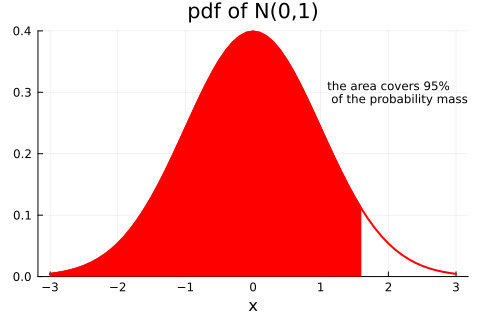

In [4]:
x  = -3:0.1:3
xb = x[x.<=1.645]                 #pick out x values <= 1.645

pdfx  = pdf.(Normal(0,1),x)       #calculate the pdf of a N(0,1) variable
pdfxb = pdf.(Normal(0,1),xb)

p1 = plot( x,pdfx,                        #plot pdf
           linecolor = :red,
           linewidth = 2,
           legend = nothing,
           ylims = (0,0.4),
           title = "pdf of N(0,1)",
           xlabel = "x",
           annotation = (1.1,0.3,text("the area covers 95%\n of the probability mass",:left,8)) )
plot!(xb,pdfxb,linecolor=:red,linewidth=2,legend=nothing,fill=(0,:red))    #plot area under pdf
display(p1)

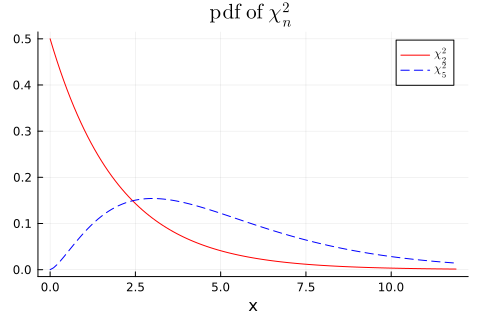

In [5]:
x  = 0.0001:0.1:12

pdf2  = pdf.(Chisq(2),x)         #pdf of Chisq(2)
pdf5 =  pdf.(Chisq(5),x)

p1 = plot( x,[pdf2 pdf5],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           label = [L"\chi_{2}^{2}" L"\chi_{5}^{2}"],
           title = L"\mathrm{pdf\ of\ } \chi_{n}^{2}",  #use \ to get spacing
           xlabel = "x" )
display(p1)

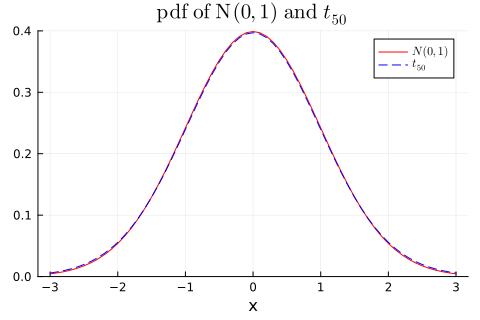

In [6]:
x  = -3:0.1:3

pdfN   = pdf.(Normal(0,1),x)
pdft50 = pdf.(TDist(50),x)            #pdf of t-dist with 50 df

p1 = plot( x,[pdfN pdft50],
           linecolor = [:red :blue],
           linestyle = [:solid :dash],
           label = [L"N(0,1)" L"t_{50}"],
           ylims = (0,0.4),
           title = L"\mathrm{pdf \ of \ N(0,1) \ and \ } t_{50}",
           xlabel = "x" )
display(p1)

## Cumulative Distribution Function (cdf)

The cdf calculates the probability for the random variable (here denoted $y$) to be below or at a value $x$, for instance, $\textrm{cdf}(x) = \textrm{Pr}(y\leq x)$.

Also, we can calculate the probability that $y$ exceeds $x$, $\textrm{Pr}( x \lt y)$ as $1 - \textrm{cdf}(x)$ and $\textrm{Pr}(x_1 < y\leq x_2)$ as $\textrm{cdf}(x_2)-\textrm{cdf}(x_1)$.

### A Remark on the Code

$1 - \textrm{cdf}(x)$ can be coded as `1-cdf(dist,x)` where `dist` is, for instance, `Chisq(2)`. Alternatively, we could also use `ccdf(dist,x)`. (The extra `c` stands for the complement.) 

In [7]:
printblue("Probability of:\n")
printlnPs("y<=-1.645 when y is N(0,1) ",cdf(Normal(0,1),-1.645))
printlnPs("y<=0 when y is N(0,1)      ",cdf(Normal(0,1),0))
printlnPs("2<y<=3 when y is N(0,2)    ",cdf(Normal(0,sqrt(2)),3)-cdf(Normal(0,sqrt(2)),2))
printlnPs("2<y<=3 when y is N(1,2)    ",cdf(Normal(1,sqrt(2)),3)-cdf(Normal(1,sqrt(2)),2))

printlnPs("\ny>4.61 when y is Chisq(2)  ",1-cdf(Chisq(2),4.61)," or ", ccdf(Chisq(2),4.61))
printlnPs("y>9.24 when y is Chisq(5)  ",1-cdf(Chisq(5),9.24)," or ", ccdf(Chisq(5),9.24))

Probability of:

y<=-1.645 when y is N(0,1)      0.050
y<=0 when y is N(0,1)           0.500
2<y<=3 when y is N(0,2)         0.062
2<y<=3 when y is N(1,2)         0.161

y>4.61 when y is Chisq(2)       0.100       or      0.100
y>9.24 when y is Chisq(5)       0.100       or      0.100


## Quantiles (percentiles)

...are just about inverting the cdf. For instance, the 5th percentile is the value $q$ such that cdf($q)=0.05$.

In [8]:
N_q     = quantile.(Normal(0,1),[0.025,0.05])
Chisq_q = quantile(Chisq(5),0.9)

printblue("\npercentiles:")
printlnPs("2.5th and 5th percentiles of a N(0,1) ",N_q)
printlnPs("90th percentile of a Chisquare(5)     ",Chisq_q)


percentiles:
2.5th and 5th percentiles of a N(0,1)     -1.960    -1.645
90th percentile of a Chisquare(5)          9.236


## Confidence Bands and t-tests

Suppose we have a point estimate equal to the value $b$ and it has a standard deviation of $\sigma$. The next few cells create an approximate 90% confidence band around the point estimate (assuming it is normally distributed) and test various null hypotheses.

To get a somewhat more exact confidence band, replace 1.645 by `quantile(Normal(0,1),0.05)`.

In [9]:
b = 0.5                                         #an estimate (a random variable)
σ = 0.15                                        #std of the estimate. Do \sigma[Tab] to get σ
confB = [(b-1.645*σ) (b+1.645*σ)]               #confidence band of the estimate

printlnPs("90% confidence band around the point estimate:",confB)
println("If the null hypothesis is outside this band, then it is rejected")

90% confidence band around the point estimate:     0.253     0.747
If the null hypothesis is outside this band, then it is rejected


In [10]:
tstat1 = (b - 0.4)/σ      #testing H₀: coefficient is 0.4
tstat2 = (b - 0.746)/σ    #testing H₀: coefficient is 0.746
tstat3 = (b - 1)/σ        #testing H₀: coefficient is 1.0

printblue("t-stats for different tests: are they beyond [-1.64,1.64]?\n")
rowNames = ["H₀: 0.4","H₀: 0.746","H₀: 1"]     #Do H\_0[TAB] to get H₀
printmat([tstat1,tstat2,tstat3];colNames=["t-stat"],rowNames)  #or rowNames=rowNames

printred("compare with the confidence band")

t-stats for different tests: are they beyond [-1.64,1.64]?

             t-stat
H₀: 0.4       0.667
H₀: 0.746    -1.640
H₀: 1        -3.333

compare with the confidence band


## Load Data from a csv File

In [11]:
x = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)

                #yearmonth, market, small minus big, high minus low
(ym,Rme,RSMB,RHML) = [x[:,i] for i=1:4]

println("Sample period: ",ym[1]," to ",ym[end])    #just numbers, not converted to Dates

Sample period: 197901.0 to 201104.0


## Means and Standard Deviations

If $\text{std}(x)$ equals $\sigma$ and $x$ is iid, then $\text{std}(\bar{x})$ equals $\sigma/\sqrt{T}$. This can be used to test hypotheses, for instance, that the mean is zero.

In [12]:
xbar = mean([Rme RHML],dims=1)    #,dims=1 to calculate average along a column
σ    = std([Rme RHML],dims=1)
T    = length(Rme)

printmat([xbar;σ],colNames=["Rme","HML"],rowNames=["average","std"])

              Rme       HML
average     0.602     0.330
std         4.604     3.127



In [13]:
printblue("std of sample average (assuming iid data):\n")

StdAvg = σ/sqrt(T)
tstat  = xbar./StdAvg    #testing if the means are zero

printmat([xbar;StdAvg;tstat],colNames=["Rme","HML"],rowNames=["average","std(average)","t-stat"])

std of sample average (assuming iid data):

                   Rme       HML
average          0.602     0.330
std(average)     0.234     0.159
t-stat           2.575     2.079



## Skewness, Kurtosis and Jarque-Bera

We here construct the skewness, kurtosis and JB statistics ourselves. Otherwise, you could use the functions in the `StatsBase.jl` package.

The easiest approach is apply the tests to standardised data, $x = (y-\mu)/\sigma$.

Under the null hypothesis ($x$ is $N(0,1)$), the skewness estimate is distributed as $N(0,6/T)$ and the kurtosis as $N(3,24/T)$. Since the two estimates two are independent, the Jarque-Bera test is just an application of the principle that 
$v^2 + w^2 \sim \chi^2_2$ 
if $v$ and $w$ are both distributed as $N(0,1)$ and independent. To implement it, calculate

$
(\mathrm{skewness}/\sqrt{6/T})^2 + ((\mathrm{kurtosis} -3)/\sqrt{24/T})^2
$

(see below)

In [14]:
x        = (Rme .- mean(Rme))./std(Rme)    #standardise to get zero mean and unit variance
skewness = mean(x.^3)
kurtosis = mean(x.^4)

σ_skew     = sqrt(6/T)
σ_kurtosis = sqrt(24/T)

JB = (skewness/σ_skew)^2 + ((kurtosis-3)/σ_kurtosis)^2  #Chisq(2)

printblue("Skewness, kurtosis and Jarque-Bera:\n")
xx = [skewness,kurtosis,JB]
printmat(xx,colNames=["stat"],rowNames=["Skewness","Kurtosis","Jarque-Bera"])

Skewness, kurtosis and Jarque-Bera:

                 stat
Skewness       -0.806
Kurtosis        5.347
Jarque-Bera   131.128



## Covariances and Correlations

Let $\rho$ be the estimated correlation coefficient. Under the null hypothesis of no correlation, $\sqrt{T}\frac{\rho}{\sqrt{1-\rho}^{2}}$ is distributed as $N(0,1)$, that is, it's a t-stat.

In [15]:
println("\ncov([Rme RHML]) matrix: ")
printmat(cov([Rme RHML]))

println("\ncor([Rme RHML]) matrix: ")
printmat(cor([Rme RHML]))

ρ = cor(Rme,RHML)
tstat = sqrt(T)*ρ/sqrt(1-ρ^2)

printlnPs("correlation and its t-stat:",ρ,tstat)


cov([Rme RHML]) matrix: 
    21.197    -4.875
    -4.875     9.775


cor([Rme RHML]) matrix: 
     1.000    -0.339
    -0.339     1.000

correlation and its t-stat:    -0.339    -7.090


## For Data with Missing Values (indicated by `NaN` or `missing`)

We can use either the `excise()` or the `FindNN()` functions from the `FinEcmt_OLS` module.

Alternatively, consider the [NaNStatistics.jl](https://github.com/brenhinkeller/NaNStatistics.jl) package.

In [16]:
x = [1 11;NaN 12;3 33]

μ₁ = mean(excise(x),dims=1)       #excise(x) cuts rows with any NaN/missing

vv = FindNN(x)                    #finds rows without any NaN/missing
μ₂ = mean(x[vv,:],dims=1)

printblue("averages estimated in different ways (to handle NaN/missing):")
printmat([μ₁;μ₂];rowNames=["excise","FindNN"],colNames=["x₁","x₂"])

averages estimated in different ways (to handle NaN/missing):
              x₁        x₂
excise     2.000    22.000
FindNN     2.000    22.000

